# Kidney Exchange QAOA Example

Author: Bill Wisotsky  

---

Currently, more than 100,000 patients are on the waiting list in the United States for a kidney transplant from a deceased donor. This is addressed by a program called the Kidney Exchange Program. This program won the 2012 Nobel Prize in Economics for Alvin E. Roth and Lloyd S. Shapley's contributions to the theory of stable matchings and the design of markets.

In summary, in a donor pair, the recipient needs a kidney transplant and a donor is willing to give a kidney to the recipient. About $\frac{1}{3}$ of those pairs are not compatible for a direct exchange. This is tackled by considering two incompatible pairs together: Donor 1 may be compatible with Recipient 2, and Donor 2 may be compatible with Recipient 1. In this example, a two-way swap becomes feasible. This is the core of the kidney exchange program.  

This is considered an NP-Hard combinatorial optimization problem that becomes exponentially more difficult as the size of the pool increases. The longest chain in history involved 35 tranplants in the United States in 2015.

In [1]:
import warnings
from itertools import product
from typing import List, Tuple, cast  # noqa

import networkx as nx  # noqa
import numpy as np

from classiq import *

warnings.filterwarnings("ignore")

## Creating a Pyomo Model for a Simple Kidney Exchange Problem 

In this very simple example, patients and donors represent sets of patients who receive a kidney from a donor. Compatibility is a dictionary mapping of patient-donor pairs to their compatibility scores. Binary decision variables are defined for each patient-donor pair `x[donor,patient]`. The objective is to maximize the total compatibility score: 

$ Maximize \sum_{d,p\in A}^{} \sum_{m\in M}c_{dp}x_{dpm}$ 
where 
- d=donors 
- p=patients 
- c=compatability score

Contraints are added to ensure that each donor donates only once $\sum_{d,p\in A}^{}x_{dpm} = y_{dm}$ and each patient receives once $\sum_{d,p\in A}^{}x_{dpm} = y_{pm}$. 

Create a PYOMO model to feed into Classiq, as illustrated in the Classiq documentation. Start by solving with a classical solver to get initial results for comparison to the QAOA results at the end.

In [2]:
from pyomo.environ import *

# Sample data: patient-donor pairs and compatibility scores
donors = ["donor1", "donor2", "donor3"]
patients = ["patient1", "patient2", "patient3"]
N = len(patients)
M = len(donors)
# Parameters
compatibility_scores = {
    ("donor1", "patient1"): 0.9,
    ("donor1", "patient2"): 0.7,
    ("donor1", "patient3"): 0.6,
    ("donor2", "patient1"): 0.8,
    ("donor2", "patient2"): 0.75,
    ("donor2", "patient3"): 0.65,
    ("donor3", "patient1"): 0.85,
    ("donor3", "patient2"): 0.8,
    ("donor3", "patient3"): 0.7,
}

# Create Pyomo model
model = ConcreteModel()

# Variables
model.x = Var(donors, patients, within=Binary)

# Objective
model.obj = Objective(
    expr=sum(
        compatibility_scores[donor, patient] * model.x[donor, patient]
        for donor in donors
        for patient in patients
    ),
    sense=maximize,
)

# Constraints
model.donor_constraint = ConstraintList()
for donor in donors:
    model.donor_constraint.add(
        sum(model.x[donor, patient] for patient in patients) <= 1
    )

model.patient_constraint = ConstraintList()
for patient in patients:
    model.patient_constraint.add(sum(model.x[donor, patient] for donor in donors) <= 1)

# Install "glpk" and unommente for runing this part
# Solve
# solver = SolverFactory("glpk")
# solver.solve(model)

# Output
print("\033[1m\033[4mOptimal solution:\033[0m")
for donor in donors:
    for patient in patients:
        if model.x[donor, patient].value == 1:
            print(f"{donor} donates kidney to {patient}")

print("\n\033[1m\033[4mModel Details\033[0m")
model.pprint()

Optimal solution:

Model Details
1 Var Declarations
    x : Size=9, Index={donor1, donor2, donor3}*{patient1, patient2, patient3}
        Key                    : Lower : Value : Upper : Fixed : Stale : Domain
        ('donor1', 'patient1') :     0 :  None :     1 : False :  True : Binary
        ('donor1', 'patient2') :     0 :  None :     1 : False :  True : Binary
        ('donor1', 'patient3') :     0 :  None :     1 : False :  True : Binary
        ('donor2', 'patient1') :     0 :  None :     1 : False :  True : Binary
        ('donor2', 'patient2') :     0 :  None :     1 : False :  True : Binary
        ('donor2', 'patient3') :     0 :  None :     1 : False :  True : Binary
        ('donor3', 'patient1') :     0 :  None :     1 : False :  True : Binary
        ('donor3', 'patient2') :     0 :  None :     1 : False :  True : Binary
        ('donor3', 'patient3') :     0 :  None :     1 : False :  True : Binary

1 Objective Declarations
    obj : Size=1, Index=None, Active=True
  

## Generating the QAOA Process
  
### Creating Parameters for the Quantum Circuit
Create the initial parameters, modifying them when necessary:
1. Define the number of layers (`num_layers`) of the QAOA ansatz.  
2. Define `penalty_energy` for invalid solutions, which influences the convergence rate. While smaller positive values are preferred, you may have to tweak them. 

In [3]:
from classiq.applications.combinatorial_optimization import CombinatorialProblem

combi = CombinatorialProblem(pyo_model=model, num_layers=5, penalty_factor=2)

# defining constraint such as computer and parameters for a quicker and more optimized circuit.
preferences = Preferences(transpilation_option="none", timeout_seconds=300)
constraints = Constraints(optimization_parameter="width")

qmod = combi.get_model(preferences=preferences, constraints=constraints)

### Forming the QAOA model as a Qmod

Combine everything together to form the entire QAOA model as a Qmod:
1. Synthesize the quantum model.
2. Show the quantum model in the Classiq platform.

In [4]:
qprog = combi.get_qprog()
show(qprog)

Quantum program link: https://platform.classiq.io/circuit/38w9AMvPrjARQZZpLPqme8FocHc


https://platform.classiq.io/circuit/38w9AMvPrjARQZZpLPqme8FocHc?login=True&version=15

### Defining the Classical Optimizer Part of the QAOA

Modify these parameters:
- `max_iterations` – maximum number of optimizer iterations, set to 100.  
- `quantile` – describes the quantile considered in the CVaR expectation value. See [[1](#cvar)] for more information.
   
Execute the quantum model and store the result.

In [5]:
optimized_params = combi.optimize(maxiter=100, quantile=0.7)

View the convergence graph.  
**NOTE: When looking at the graph, recall that this is a maximization problem.**

Text(0.5, 1.0, 'Cost convergence')

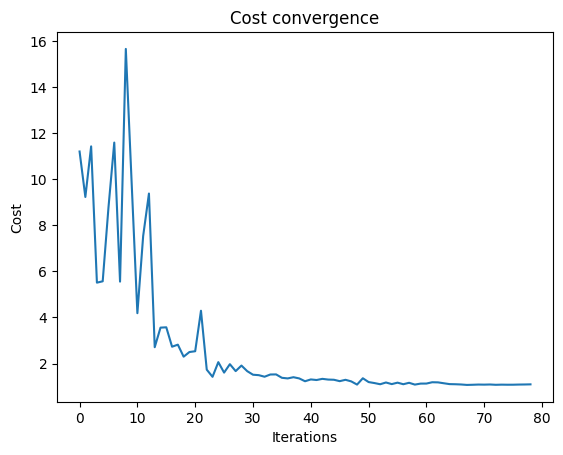

In [6]:
import matplotlib.pyplot as plt

plt.plot(combi.cost_trace)
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.title("Cost convergence")

## Retrieving and Displaying the Solutions
To view the solutions:
- Print them out
- Graph them using a histogram
- Show `Donor - Recipients` in Network Graph

### Print Best Solutions
Print out the top 10 solutions with the highest cost or objective:

In [7]:
optimization_result = combi.sample(optimized_params)

print("\n\033[1m\033[4mTop 10 Solutions\033[0m")
optimization_result.sort_values(by="cost", ascending=True).head(10)


Top 10 Solutions


,solution,probability,cost
73,"{'x_donor1_patient1': 0, 'x_donor1_patient2': ...",0.002441,-2.20
81,"{'x_donor1_patient1': 0, 'x_donor1_patient2': ...",0.002441,-2.20
203,"{'x_donor1_patient1': 0, 'x_donor1_patient2': ...",0.000977,-2.20
193,"{'x_donor1_patient1': 0, 'x_donor1_patient2': ...",0.000977,-2.20
163,"{'x_donor1_patient1': 1, 'x_donor1_patient2': ...",0.000977,-1.70
83,"{'x_donor1_patient1': 1, 'x_donor1_patient2': ...",0.001953,-1.65
51,"{'x_donor1_patient1': 1, 'x_donor1_patient2': ...",0.003418,-1.60
206,"{'x_donor1_patient1': 0, 'x_donor1_patient2': ...",0.000977,-1.60
36,"{'x_donor1_patient1': 1, 'x_donor1_patient2': ...",0.004395,-1.55
27,"{'x_donor1_patient1': 0, 'x_donor1_patient2': ...",0.004883,-1.50


### Histogram of Cost, Weighted by Probability

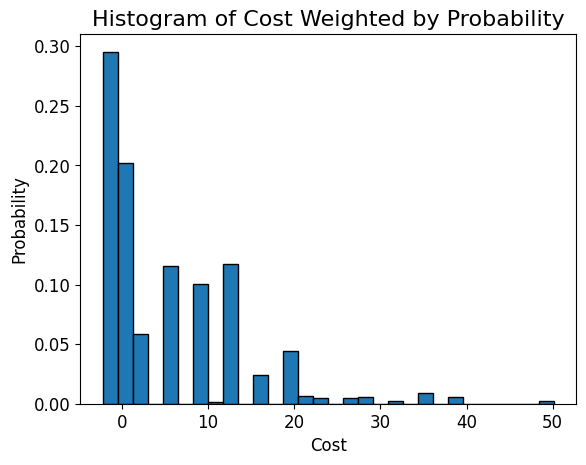

In [8]:
import matplotlib.pyplot as plt

optimization_result["cost"].plot(
    kind="hist", bins=30, edgecolor="black", weights=optimization_result["probability"]
)
plt.ylabel("Probability", fontsize=12)
plt.xlabel("Cost", fontsize=12)
plt.tick_params(axis="both", labelsize=12)
plt.title("Histogram of Cost Weighted by Probability", fontsize=16)
plt.show()

### Creating a Network Graph 
Create a network graph for the best solution found.

**NOTE: This is a maximization problem and the classical solver of the QAOA process returns all possible results.** 

Filter out the solution with the highest cost that represents the the highest compatability score:

** QAOA SOLUTION **
Highest Compatibility Score =  2.2
        patient1  patient2  patient3
donor1         0         1         0
donor2         0         0         1
donor3         1         0         0


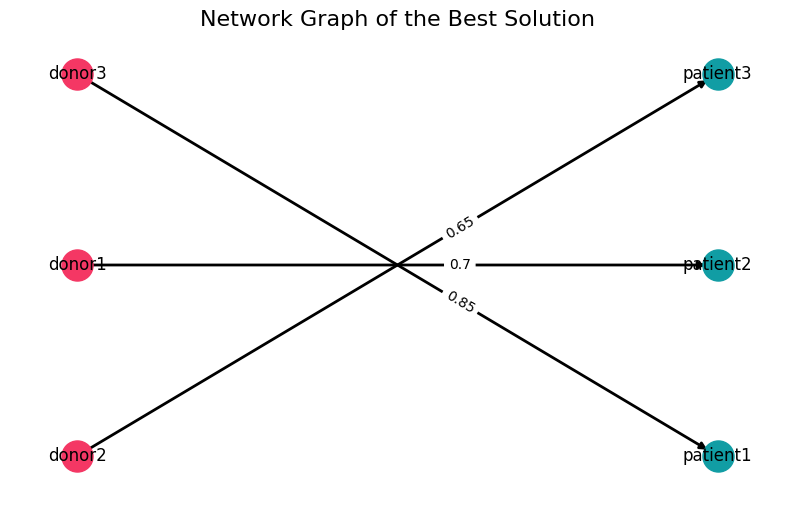

In [9]:
from itertools import product

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd


def plotting_sol(x_sol, cost):
    # Extract donor and patient names from keys
    donors = sorted(set(key.split("_")[1] for key in x_sol.keys()))
    patients = sorted(set(key.split("_")[2] for key in x_sol.keys()))
    N = len(donors)
    M = len(patients)

    # Create mapping to matrix
    x_mat = np.zeros((N, M), dtype=int)
    for key, val in x_sol.items():
        donor = key.split("_")[1]
        patient = key.split("_")[2]
        i = donors.index(donor)
        j = patients.index(patient)
        x_mat[i, j] = val

    print("\033[1m\033[4m** QAOA SOLUTION **\033[0m")
    print("\033[4mHighest Compatibility Score\033[0m = ", cost)

    # Table view
    df = pd.DataFrame(x_mat, index=donors, columns=patients)
    print(df)

    # Graph view
    graph_sol = nx.DiGraph()
    graph_sol.add_nodes_from(donors + patients)

    for i, j in product(range(N), range(M)):
        if x_mat[i, j] > 0:
            graph_sol.add_edge(
                donors[i],
                patients[j],
                weight=compatibility_scores[(donors[i], patients[j])],
            )  # Default weight

    plt.figure(figsize=(10, 6))
    pos = nx.bipartite_layout(graph_sol, donors)

    nx.draw_networkx_nodes(
        graph_sol, pos, nodelist=donors, node_color="#F43764", node_size=500
    )
    nx.draw_networkx_nodes(
        graph_sol, pos, nodelist=patients, node_color="#119DA4", node_size=500
    )
    nx.draw_networkx_labels(graph_sol, pos, font_size=12)

    nx.draw_networkx_edges(graph_sol, pos, width=2)
    labels = nx.get_edge_attributes(graph_sol, "weight")
    nx.draw_networkx_edge_labels(
        graph_sol, pos, edge_labels=labels, font_size=10, label_pos=0.6
    )

    plt.title("Network Graph of the Best Solution", fontsize=16)
    plt.axis("off")
    plt.show()


best_solution = optimization_result.loc[optimization_result.cost.idxmin()]
plotting_sol(best_solution.solution, -best_solution.cost)

## Reference
<a id='cvar'>[1]</a> [Barkoutsos, P. K., Nannicini, G., Robert, A., Tavernelli, I., & Woerner, S. (2020). Improving variational quantum optimization using CVaR. Quantum, 4, 256.](https://arxiv.org/abs/1907.04769)